}# League of Legends Project - Machine Learning Predictions
In this notebook I will make a predictive model for the results of League of Legends games using both Logistic Regression and Gradient Boosting.

I will use 2 sets of features.  The first are the elo ratings I calculated in LoL_Elo_System, and the second are the champions selected by each team.
***

However, before I do this I need to engage in data engineering, to reshape the dataframe to include all of the data for each game on a single row.  Because the elo ratings I calculated in the LoL_Elo_System notebook, and stored in elolol.pkl, are reshaped so that the data is split by winning and losing team rather than by Red and Blue side, I will have to reshape that dataframe as well.

I will then evaluate the effectiveness of the models.

***
# Step 1: Dataset Creation

**A note on the data.**

Usually, a major restriction in machine learning is the sample size, but the dataset for professional LoL has a sample size nearly as large as the population size, and the small population size poses a significant problem when using Champions features.  Due to there being over 170 champions, there simply aren't many combinations of champions that are occur enough times for the models to measure their impact on the result of the game.

There are two possible ways to fix this problem, neither of which is sufficient.  The first is to utilise publicly available data from non-professional games.  However, we know, from LoL game designer David Turley, that there are large differences in Champion interactions, between professional teams and non-professionals.  The second is to use "scrimmage" games that professional teams play between each other to practice.  However, these games are not made public and are not publicly available.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss, log_loss
from sklearn.metrics import brier_score_loss

import seaborn as sns
import matplotlib.pyplot as plt

import json
import shap

In [2]:
# Reading in the data
dflol = pd.read_pickle("dflol.pkl")

In [3]:
dflol.head()

,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,1,...,206.0,76.0,-512.0,-18.0,3.0,4.0,0.0,1.0,2.0,2.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,2,...,140.0,-888.0,351.0,-42.0,0.0,5.0,3.0,2.0,1.0,1.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,3,...,225.0,621.0,733.0,8.0,1.0,5.0,1.0,1.0,2.0,0.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,4,...,161.0,3265.0,1950.0,50.0,6.0,2.0,0.0,0.0,0.0,4.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,5,...,28.0,1780.0,2397.0,-19.0,0.0,7.0,0.0,0.0,1.0,3.0


In [4]:
# Feature Selection.  I am only selecting the champions selected ("champion"), and the champions banned ("ban1", "ban2" etc.)
dflol = dflol[["result", "position", "side", "champion", "ban1", "ban2", "ban3", "ban4", "ban5"]]

In [5]:
dflol.isna().sum()/len(dflol)

result      0.000000
position    0.000000
side        0.000000
champion    0.166667
ban1        0.025580
ban2        0.023444
ban3        0.024864
ban4        0.107112
ban5        0.109405
dtype: float64

There were initially only 3 bans in LoL, but in 2017 this was changed to 5.  For games between 2014 and 2016, the columns ban4 and ban5 are NaNs.

In [6]:
dflol.head(12)

,result,position,side,champion,ban1,ban2,ban3,ban4,ban5
gameid,,,,,,,,,
TRLH3/33,1,top,Blue,Trundle,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,1,jng,Blue,Vi,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,1,mid,Blue,Orianna,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,1,bot,Blue,Jinx,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,1,sup,Blue,Annie,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,0,top,Red,Dr. Mundo,Kassadin,Nidalee,Elise,NaN,NaN
TRLH3/33,0,jng,Red,Shyvana,Kassadin,Nidalee,Elise,NaN,NaN
TRLH3/33,0,mid,Red,LeBlanc,Kassadin,Nidalee,Elise,NaN,NaN
TRLH3/33,0,bot,Red,Lucian,Kassadin,Nidalee,Elise,NaN,NaN


In [7]:
positions = ["top", "jng", "mid", "bot", "sup", "team"]
positions_list = []

for i in range(6):
    # Create 6 dataframes for the 5 positions plus the team stats.
    positions_list.append(dflol[dflol["position"] == positions[i]])


for i in range(len(positions_list)):

    positions_list[i] = positions_list[i].drop("position", axis=1)

    # Keep only 1 column with the result.
    if i > 0:
        positions_list[i] = positions_list[i].drop(["result", "side"], axis=1)

    if i == 5:
        positions_list[i] = positions_list[i].drop("champion", axis=1)
    else:
        positions_list[i] = positions_list[i].drop(["ban1", "ban2", "ban3", "ban4", "ban5"], axis=1)

    # Add prefixes of the positions for the column names.
    new_columns = []
    for c in positions_list[i].columns.to_list():
        c = positions[i] + "_" + c
        new_columns.append(c)
    positions_list[i].columns = new_columns

# Merge the 6 dataframes together.
blue_red_df = pd.concat([positions_list[0],
                         positions_list[1],
                         positions_list[2],
                         positions_list[3],
                         positions_list[4],
                         positions_list[5]],
                         axis=1).rename({"top_result":"result", "top_side":"side"}, axis=1)

In [8]:
blue_red_df.head()

,result,side,top_champion,jng_champion,mid_champion,bot_champion,sup_champion,team_ban1,team_ban2,team_ban3,team_ban4,team_ban5
gameid,,,,,,,,,,,,
TRLH3/33,1,Blue,Trundle,Vi,Orianna,Jinx,Annie,Riven,Kha'Zix,Yasuo,NaN,NaN
TRLH3/33,0,Red,Dr. Mundo,Shyvana,LeBlanc,Lucian,Thresh,Kassadin,Nidalee,Elise,NaN,NaN
TRLH3/44,1,Blue,Shyvana,Elise,Kayle,Lucian,Lulu,Lee Sin,Annie,Yasuo,NaN,NaN
TRLH3/44,0,Red,Renekton,Vi,Gragas,Caitlyn,Thresh,Kassadin,Kha'Zix,Ziggs,NaN,NaN
TRLH3/76,0,Blue,Shyvana,Lee Sin,Gragas,Vayne,Thresh,Kassadin,Annie,Orianna,NaN,NaN


In [9]:
# Change the index for the purposes of moving all the data from both red and blue teams onto the same row.


# Split the data into 2 dataframes, one dataframe for the team on blue side, the other for the team on red side.
blue_df = (blue_red_df[blue_red_df["side"] == "Blue"]
           .drop("side",axis=1)
           .add_prefix("blue_", axis=1))

# In order to keep only 1 result column, I will drop "top_result" from red_df.
red_df = (blue_red_df[blue_red_df["side"] == "Red"]
          .drop(["side", "result"], axis=1)
          .add_prefix("red_", axis=1))

# Merge the 2 dataframes together so that each game occupies only a single row.
champions_df = blue_df.merge(red_df, on="gameid")

In [10]:
champions_df.head()

,blue_result,blue_top_champion,blue_jng_champion,blue_mid_champion,blue_bot_champion,blue_sup_champion,blue_team_ban1,blue_team_ban2,blue_team_ban3,blue_team_ban4,...,red_top_champion,red_jng_champion,red_mid_champion,red_bot_champion,red_sup_champion,red_team_ban1,red_team_ban2,red_team_ban3,red_team_ban4,red_team_ban5
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,Trundle,Vi,Orianna,Jinx,Annie,Riven,Kha'Zix,Yasuo,NaN,...,Dr. Mundo,Shyvana,LeBlanc,Lucian,Thresh,Kassadin,Nidalee,Elise,NaN,NaN
TRLH3/44,1,Shyvana,Elise,Kayle,Lucian,Lulu,Lee Sin,Annie,Yasuo,NaN,...,Renekton,Vi,Gragas,Caitlyn,Thresh,Kassadin,Kha'Zix,Ziggs,NaN,NaN
TRLH3/76,0,Shyvana,Lee Sin,Gragas,Vayne,Thresh,Kassadin,Annie,Orianna,NaN,...,Renekton,Vi,Ziggs,Jinx,Leona,Yasuo,Elise,LeBlanc,NaN,NaN
TRLH3/85,1,Warwick,Lee Sin,Kha'Zix,Jinx,Kennen,Kayle,Annie,Elise,NaN,...,Shyvana,Olaf,Zyra,Lucian,Lulu,Dr. Mundo,Yasuo,Kassadin,NaN,NaN
TRLH3/10072,0,Shyvana,Lee Sin,Ziggs,Lucian,Leona,Gragas,Yasuo,Riven,NaN,...,Renekton,Vi,LeBlanc,Ezreal,Annie,Evelynn,Elise,Dr. Mundo,NaN,NaN


***
### Elo Data
I will incorporate the elo ratings created in LoL_Elo_System into my dataset.

In [11]:
# Read in the elo_record dataframe.
elo_record_df = pd.read_pickle("elolol.pkl").drop(["predict", "probability", "team_earned_gpm_ratio"], axis=1)

# Drop all "id" columns and the "year" column.
elo_record_df = elo_record_df[elo_record_df.columns.drop(list(elo_record_df.filter(regex="teamid|playerid")))].drop("year", axis=1)

In [12]:
elo_record_df.head()

,side,win_top_elo,win_jng_elo,win_mid_elo,win_bot_elo,win_sup_elo,win_team_elo,win_total_elo,lose_top_elo,lose_jng_elo,lose_mid_elo,lose_bot_elo,lose_sup_elo,lose_team_elo,lose_total_elo
gameid,,,,,,,,,,,,,,,
TRLH3/33,1,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294
TRLH3/44,1,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294
TRLH3/76,-1,1502.336846,1502.759282,1503.14039,1504.322694,1503.619229,1503.433287,11325.403959,1497.714434,1497.301268,1496.928523,1495.772163,1496.460191,1496.642053,11277.701822
TRLH3/85,1,1497.663154,1497.240718,1496.85961,1495.677306,1496.380771,1496.566713,11277.172629,1502.285566,1502.698732,1503.071477,1504.227837,1503.539809,1503.357947,11324.874766
TRLH3/10072,-1,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,11301.288294,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,11301.288294


Reshaping the dataframe from having the elo ratings defined by the winning and losing team, to the columns being defined by Blue side and Red side.

In [13]:
# Split the dataframe into red and blue.  in LoL_Elo_System I coded the "side" column into 1 for Blue and -1 for Red.
elo_blue_df = elo_record_df[elo_record_df["side"] == 1]
elo_red_df = elo_record_df[elo_record_df["side"] == -1]

# Add changed column titles.
# The games in elo_blue_df are all the games that the team on Blue side team won.
# The games in elo_red_df are all the games that the team on Red side won.
elo_blue_df.columns = (elo_blue_df.columns
                       .str.replace("win", "blue")
                       .str.replace("lose", "red"))

elo_red_df.columns = (elo_red_df.columns
                      .str.replace("win", "red")
                      .str.replace("lose", "blue"))

# Join the 2 dataframes back together.
blue_red_elo_record_df = pd.concat([elo_blue_df, elo_red_df]).drop("side", axis=1)

# Add a new column for the difference between the total elo ratings of each team.
blue_red_elo_record_df["elo_diff"] = blue_red_elo_record_df["blue_total_elo"] - blue_red_elo_record_df["red_total_elo"]

# Merge the elo_record with the other features.
champion_elo_df = champions_df.merge(blue_red_elo_record_df, on="gameid")

### One Hot Encoding the Data

In [14]:
# One Hot Encoding the bans using MulitLabelBinarizer to disregard the order of bans and increase the sample size.
mlb = MultiLabelBinarizer()
for side in ["blue", "red"]:
    # Listing all of the bans.
    team_ban_columns = [f"{side}_team_ban1", f"{side}_team_ban2", f"{side}_team_ban3", f"{side}_team_ban4", f"{side}_team_ban5"]
    team_ban_list = champion_elo_df[team_ban_columns].values.tolist()
    team_bans = [[x for x in row if pd.notna(x)] for row in team_ban_list]

    # One Hot Encoding.
    team_ban_features = mlb.fit_transform(team_bans)

    team_ban_features_df = pd.DataFrame(team_ban_features, columns=[f"{side}_team_ban_{champ}" for champ in mlb.classes_], index=champion_elo_df.index)
    champion_elo_df = champion_elo_df.drop(columns=team_ban_columns).join(team_ban_features_df)

# One hot encoding the selected Champions.
champion_cols = champion_elo_df.filter(regex="champion").columns
for col in champion_cols:
    dummies = pd.get_dummies(champion_elo_df[col], prefix=col)
    champion_elo_df = champion_elo_df.drop(columns=col).join(dummies)

In [15]:
cat_cols = champion_elo_df.filter(regex="champion|ban").columns
champion_elo_df[cat_cols] = champion_elo_df[cat_cols].astype("int8")

Initially, instead of reducing having separate features for whether a champion was selected on Red or Blue side, I had a single column for each champion, coded as 1 for Blue side, 0, for not picked and -1 for Red side.  I believed that the doubling of sample size for each feature would improve the predictive capabilities of Logistic Regression.

However, it didn't improve model accuracy, and SHAP, for XGBoost, was unable to interpret the numerical columns as having multiple categories, hampering my feature analysis.
```champion_list = list(set(col.rsplit("_", 1)[1] for col in cat_cols))

for champ in champion_list:
    blue_cols = [col for col in cat_cols if col.startswith("blue_") and col.endswith(f"_{champ}")]
    red_cols  = [col for col in cat_cols if col.startswith("red_")  and col.endswith(f"_{champ}")]

    for blue_col, red_col in zip(blue_cols, red_cols):
        champion_elo_df.loc[:, blue_col.split("_",1)[1]] = champion_elo_df.get(blue_col, 0) - champion_elo_df.get(red_col, 0)
        champion_elo_df = champion_elo_df.drop([col for col in [blue_col, red_col] if col in champion_elo_df.columns], axis=1)
    champion_elo_df = champion_elo_df.copy()```

In [16]:
from scipy.sparse import csr_matrix
sparse_champion_matrix = csr_matrix(champion_elo_df[cat_cols])

In [29]:
train_data, test_data, train_result, test_result = train_test_split(sparse_champion_matrix,
                                                                    champion_elo_df["blue_result"],
                                                                    test_size = 0.2,
                                                                    random_state=2)

# Step 2: Machine Learning
I believe that Elo_Diff will be the dominant feature of my model, and so in order to prevent the model underfitting the other features, I am engaging in two-stage modelling.

The Elo System has already been trained and so I will model the Champions that are selected and banned, and then use the predicted probabilities from that model as a feature, along with Elo_Diff in a meta model.

***

I am using Scikit-Learn's LogsiticRegression as a baseline model, but I expect the Gradient Boosting model, XGBoost to have a higher accuracy.

I am using Gradient Boosting because I suspect that there are complicated relationships between the features in the model, such as that a champion selected might have a larger impact on the result of the game when selected alongside, or against another champion.  These patterns can be picked up by Gradient Boosting models but not Logistic Regression ones.

I am using XGBoost because it is able to handle categorical data, is easily interpretable, and fast.

### Logistic Regression for Champion Data

I am using regularisation to reduce overfitting, and I am using the SAGA (Stochastic Average Gradient with Averaging) solver because it is Gradient Descent (and faster than Coordinate Descent) whilst allowing for L1 regularisation.

I am using L1 regularisation because I don't want the model to learn on noise, and I suspect that there is a lot of noise and a lot of features that don't have a meaningful impact on the result of the game.  I am not using L2 regularisation because I am not afraid of the model over-relying on just a few features.

In [50]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", max_iter=10000, penalty="l1")

param_grid = {"C":[0.01, 0.05, 0.1, 0.5, 1]}

linear_grid_search = GridSearchCV(estimator=model,
                                  param_grid=param_grid,
                                  scoring="neg_log_loss",
                                  cv=5)

linear_grid_search.fit(train_data, train_result)

# Predict.
pred_test_result  = linear_grid_search.predict(test_data)
pred_train_result = linear_grid_search.predict(train_data)

print(linear_grid_search.best_params_)

# Accuracy and report.
accuracy_test  = accuracy_score(test_result, pred_test_result)
accuracy_train = accuracy_score(train_result, pred_train_result)
brier_test     = brier_score_loss(test_result, linear_grid_search.predict_proba(test_data)[:,1])
brier_train    = brier_score_loss(train_result, linear_grid_search.predict_proba(train_data)[:,1])

print(f"Test Accuracy:  {accuracy_test:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Brier:     {brier_test:.4f}")
print(f"Train Brier:    {brier_train:.4f}")

{'C': 0.1}
Test Accuracy:  0.5588
Train Accuracy: 0.5719
Test Brier:     0.2550
Train Brier:    0.2424


### XGBoost for Champion Data
I am using tree_method="hist" to better handle categorical data, and eval_method="logloss", and scoring="neg_log_loss" because I care not only about the accuracy, but also about the calibration of the model.

I am using a min_child_weight=200 in order to reduce overfitting and the model learning on noise from the train data.  I found that combinations of regularisation parameters (including gamma, subsample and col_sample) did not decrease overfitting.  As mentioned at the start of this notebook, given the small population size, aggressive regularisation is needed to prevent the models from memorising the training data.


In [31]:
from xgboost import XGBClassifier

# Define my model and the parameters for my grid search.
model = XGBClassifier(objective="binary:logistic",
                      eval_metric="logloss",
                      tree_method="hist",
                      enable_categorical="true",
                      min_child_weight=200,
                      n_jobs=-1)

param_grid = {"n_estimators":[45, 55, 65, 75],
              "max_depth":[4, 6, 8, 10],
              "learning_rate":[0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1]}

xg_grid_search = GridSearchCV(estimator=model,
                              param_grid=param_grid,
                              scoring="neg_log_loss",
                              cv=5)

# Train and Test.
xg_grid_search.fit(train_data, train_result)

pred_test_result  = xg_grid_search.predict(test_data)
pred_train_result = xg_grid_search.predict(train_data)

# Printing the best parameters.
print(xg_grid_search.best_params_)

# Find the accuracy
accuracy_test = accuracy_score(test_result, pred_test_result)
accuracy_train = accuracy_score(train_result, pred_train_result)
brier_test = brier_score_loss(test_result, xg_grid_search.predict_proba(test_data)[:,1])
brier_train = brier_score_loss(train_result, xg_grid_search.predict_proba(train_data)[:,1])

print(f"Test Accuracy:  {accuracy_test:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Brier:     {brier_test:.4f}")
print(f"Train Brier:    {brier_train:.4f}")

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 75}
Test Accuracy:  0.5583
Train Accuracy: 0.5676
Test Brier:     0.2457
Train Brier:    0.2440


**Mini-Model Analysis**

XGBoost has a very similar Accuracy and Brier as Logistic Regression, but slightly less overfitting, so I will use its probabilities as a feature in the meta model.

## Meta Model

I am using logistic regression as the meta model because I strongly suspect that there is a linear relationship between the probabilities outputed by XGBoost, elo_diff (which is effectively probability) and the output, which is probability, of the meta model.

In [32]:
# Combining the probability from XGBoost's model based on Champions, and my Elo Ratings based on the Teams and Players.
intermediate_probability    = xg_grid_search.predict_proba(sparse_champion_matrix)[:, 1]
intermediate_probability_df = pd.DataFrame(intermediate_probability, index=champion_elo_df.index, columns=["champ_prob"]).join(champion_elo_df["elo_diff"])
ip_train_data, ip_test_data = train_test_split(intermediate_probability_df,
                                               test_size = 0.2,
                                               random_state=2)
# Standardising the Data.
scaler = StandardScaler()
scaled_ip_train_data = scaler.fit_transform(ip_train_data)
scaled_ip_test_data = scaler.transform(ip_test_data)

In [33]:
# Define and train the model.
lreg_meta_model = LogisticRegression(solver="lbfgs")

lreg_meta_model.fit(scaled_ip_train_data, train_result)

# Predict.
lreg_pred_test_result  = lreg_meta_model.predict(scaled_ip_test_data)
lreg_pred_train_result = lreg_meta_model.predict(scaled_ip_train_data)

# Accuracy and report.
lreg_accuracy_test  = accuracy_score(test_result, lreg_pred_test_result)
lreg_accuracy_train = accuracy_score(train_result, lreg_pred_train_result)
lreg_brier_test     = brier_score_loss(test_result, lreg_meta_model.predict_proba(scaled_ip_test_data)[:,1])
lreg_brier_train    = brier_score_loss(train_result, lreg_meta_model.predict_proba(scaled_ip_train_data)[:,1])
lreg_report         = classification_report(test_result, lreg_pred_test_result)

### XGBoost Meta Model

***
# Step 3: Model Analysis

In [34]:
print(f"Test Accuracy:   {lreg_accuracy_test:.4f}")
print(f"Train Accuracy:  {lreg_accuracy_train:.4f}")
print(f"Test Brier:      {lreg_brier_test:.4f}")
print(f"Train Brier:     {lreg_brier_train:.4f}")

Test Accuracy:   0.6577
Train Accuracy:  0.6570
Test Brier:      0.2146
Train Brier:     0.2147


There isn't a significant amount of overfitting.

The Accuracy and Brier score are slightly better than just using the Elo System, but not significantly better.

In [35]:
print(lreg_report)
print(f"Mean Predicted Result {lreg_pred_test_result.mean():.2f}")
print(f"Mean Actual Result {test_result.mean():.2f}")

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      7728
           1       0.67      0.72      0.69      8818

    accuracy                           0.66     16546
   macro avg       0.66      0.65      0.65     16546
weighted avg       0.66      0.66      0.66     16546

Mean Predicted Result 0.57
Mean Actual Result 0.53


2The model's Recall is 0.12 higher for predicting wins (1s) than losses (0s).  The F1-score is reasonable at 0.65, considering that the class imbalance is only 0.53.

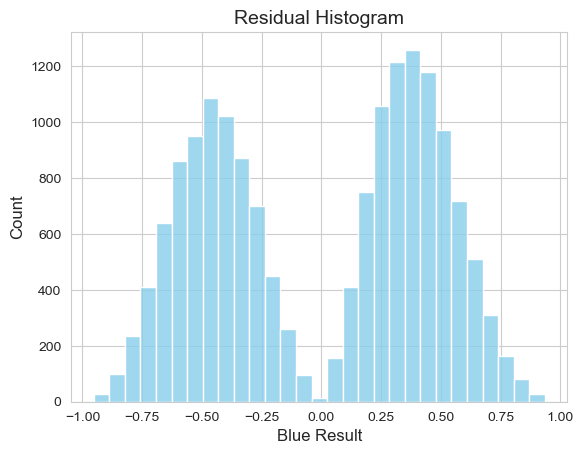

In [36]:
lreg_test_prob = lreg_meta_model.predict_proba(scaled_ip_test_data)[:,1]

lreg_test_residuals = test_result - lreg_test_prob

sns.histplot(lreg_test_residuals, color="skyblue", alpha=0.8)
plt.title("Residual Histogram", size=14)
plt.xlabel("Blue Result", size=12)
plt.ylabel("Count", size=12)
plt.show()

The model is rarely very confidently incorrect, with a low proportion of residuals being < -0.75 or > 0.75.

## Calibration Analysis

Given that the major business use of the model is in betting, I will analyse the calibration of the model.

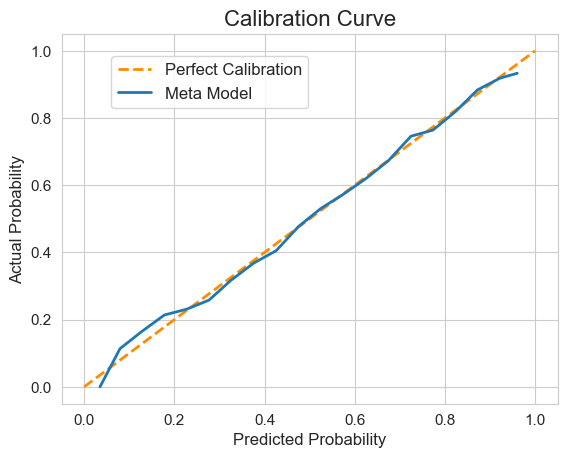

In [53]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_result, lreg_test_prob, n_bins=20)
plt.plot([0, 1], [0, 1], linestyle="--", color="darkorange", linewidth=2, label="Perfect Calibration")
plt.plot(prob_pred, prob_true, linewidth=2, label="Meta Model")

plt.title("Calibration Curve", size=16)
plt.xlabel("Predicted Probability", size=12)
plt.xticks(size=11)
plt.ylabel("Actual Probability", size=12)
plt.yticks(size=11)

plt.legend(fontsize=12, loc=(0.1,0.8))
plt.show()

The model is calibrated well, but is less accurate when the predicted probability is very small .

In [38]:
n_bins = 20
bins = np.linspace(0, 1, n_bins + 1)

# Putting each rating into a bin
binids = np.digitize(lreg_test_prob, bins) - 1
ece = 0
errors = []
bin_centres = []
for i in range(n_bins):

    # Selecting the correct bin.
    bin_mask = binids == i

    if np.any(bin_mask):
        bin_prob = lreg_test_prob[bin_mask]
        bin_true_mean = test_result[bin_mask].mean()
        mean_bin_prob = bin_prob.mean()
        errors.append(np.abs(mean_bin_prob - bin_true_mean))
        bin_centres.append(mean_bin_prob)
        bin_weight = len(bin_prob) / len(test_result)
        ece += np.abs(bin_prob.mean() - test_result[bin_mask].mean()) * bin_weight

print(f"ECE: {ece:.3f}")

ECE: 0.009


The ECE of 0.009 is very good and so the model is well calibrated

In [39]:
brier = brier_score_loss(test_result, lreg_test_prob)
dummy_brier = brier_score_loss([1,0], [0.5,0.5])

print("Brier Score measures the mean squared error of my predictions")

print(f"Brier Score: {brier:.3f}")
print(f"Random Guessing Brier Score: {dummy_brier:.3f}")

print(f"This means that it reduces the MSE compared to randomly guessing by {(1-(brier/dummy_brier))*100:.2f}%")

Brier Score measures the mean squared error of my predictions
Brier Score: 0.215
Random Guessing Brier Score: 0.250
This means that it reduces the MSE compared to randomly guessing by 14.17%


Brier doesn't just focus on calibration (ECE) but also cares about resolution, which is how well the model separates (ranks) the wins from the losses.

The Brier of 0.215 for the meta-model is barely better than the Brier of 0.218 when using just the elo ratings.  The difference appears to be negligible

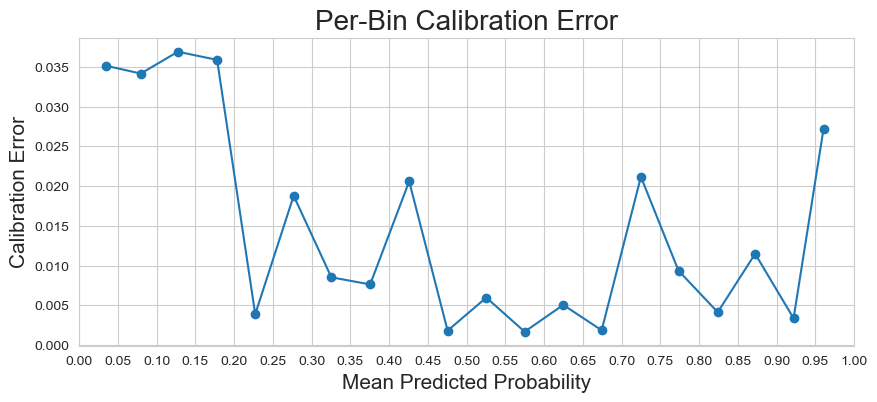

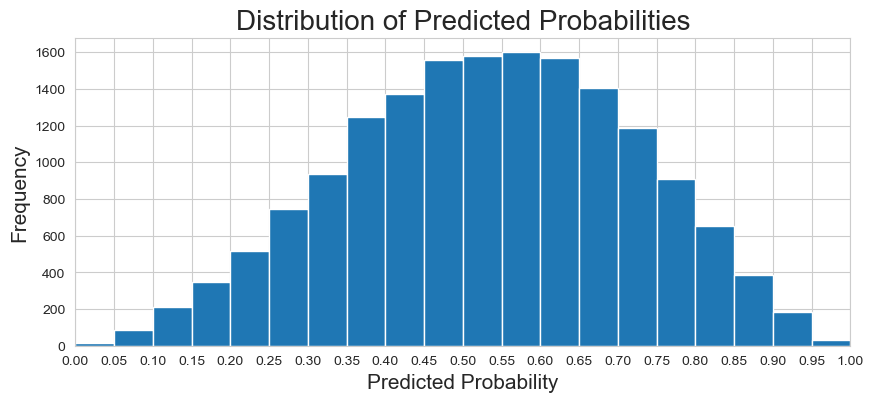

In [52]:
plt.figure(figsize=(10,4))
plt.plot(bin_centres, errors, marker="o")
plt.title("Per-Bin Calibration Error", size=20)

plt.xlabel("Mean Predicted Probability", size=15)
plt.xticks(np.arange(0,1.01,0.05))
plt.xlim([0,1])
plt.ylabel("Calibration Error", size=15)
plt.grid(True)

plt.show()

plt.figure(figsize=(10,4))
plt.hist(lreg_test_prob, bins=bins)

plt.title("Distribution of Predicted Probabilities", size=20)
plt.xlabel("Predicted Probability", size=15)
plt.xticks(np.arange(0,1.01,0.05))
plt.xlim([0,1])
plt.ylabel("Frequency", size=15)
plt.grid(True)

plt.show()

When we look at the frequency per bin, the larger ECEs are in the 4 smallest bins, and so the model is worse at predicting very small values.  The model is rarely confident in the result of a game with most predictions between 0.25 and 0.75

## Feature Importance Analysis

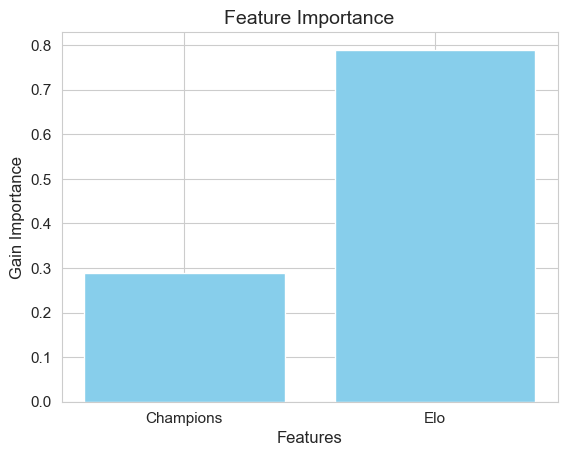

In [41]:
importance_series = pd.Series(lreg_meta_model.coef_.flatten())

plt.bar(importance_series.index, importance_series, color="skyblue")
plt.title("Feature Importance", size=14)
plt.ylabel("Gain Importance", size=12)
plt.xlabel("Features", size=12)
plt.xticks(ticks=range(2), labels=["Champions", "Elo"], size=11)
plt.yticks(size=11)

plt.show()

Elo was a more important feature chan the Champions, which I expected, and is the reason why I engaged in two-stage modelling in the first place.

I will also look at the feature selection for the intermediate model.

In [42]:
best_intermediate_model = xg_grid_search.best_estimator_

intermediate_importance_df = pd.DataFrame(best_intermediate_model.get_booster().get_score(importance_type="gain").items(),
                                              columns=["Feature", "Gain"])

print("Number of Features used:", len(intermediate_importance_df), "\nTotal Features:", len(cat_cols))

Number of Features used: 187 
Total Features: 1732


The model used only 187, out of 1732 features, which is most likely due to many champions simply not being selected or banned enough to have a notable impact on the split gain.

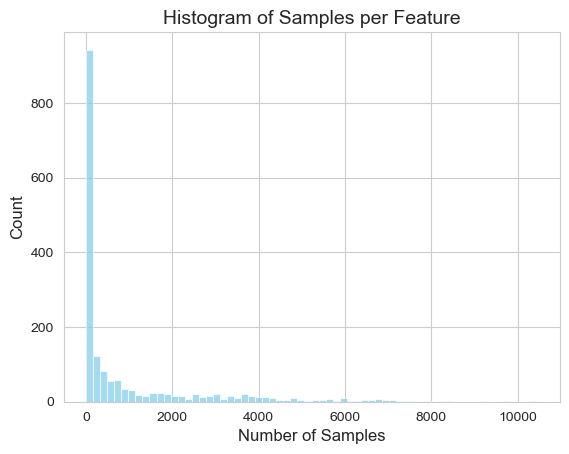

In [43]:
sns.histplot(champion_elo_df[cat_cols].sum(), color="skyblue")

plt.title("Histogram of Samples per Feature", size=14)
plt.xlabel("Number of Samples", size=12)
plt.ylabel("Count", size=12)
plt.show()

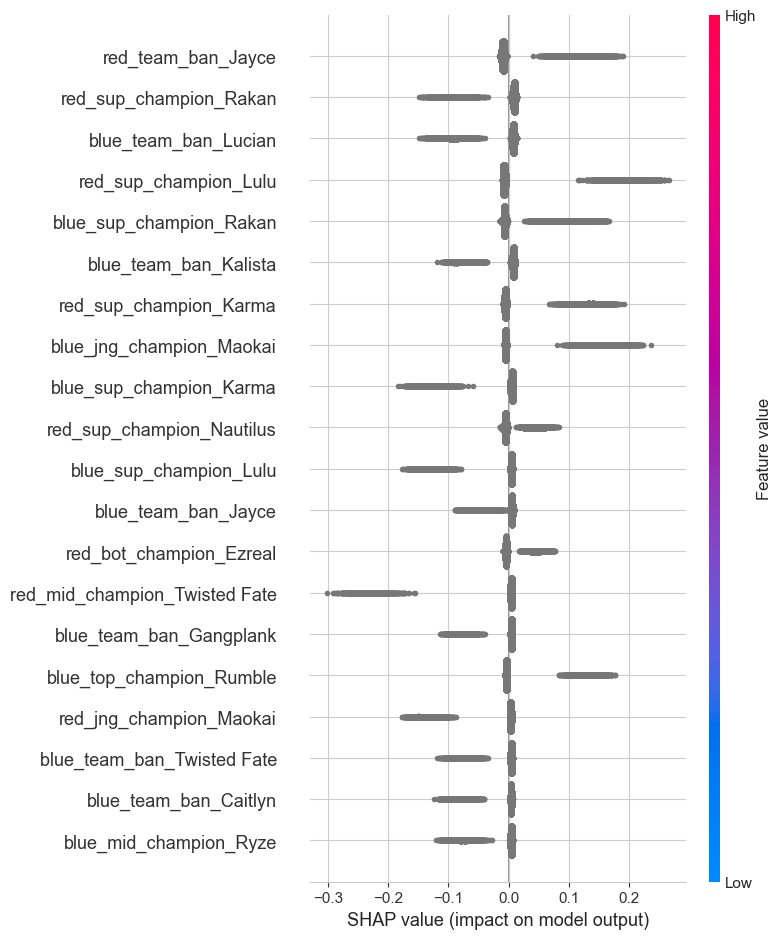

In [44]:
explainer    = shap.TreeExplainer(best_intermediate_model)
shap_values  = explainer.shap_values(train_data)

shap.summary_plot(shap_values,
                  train_data,
                  feature_names=cat_cols)

plt.show()

Of the 20 most important features, they are fairly evenly split between Champions selected and Champions banned.

We can see that certain Champions, such as Rakan and Karma, have roughly equal impact on Blue side and Red side.  The model sees Rakan as a strong Champion that increases the chances of the Blue team winning when it is selected by the Blue team, and decreases the Blue team's chances of winning when it is selected by the Red team.

Conversely, it sees Lulu as a weak champion.

***
Something that I found surprising, was how similar the accuracy, for Champions, Logistic Regression (0.551)was to Gradient Boosting (0.558).

My hypothesis was that Gradient Boosting would be notably better than Logistic Regression because of its ability to handle the relationships between features (Champions), however, this was not the case.  Therefore, I will look at the trees in XGBoost to understand why it was not better.

In [45]:
booster = best_intermediate_model.get_booster()

tree_df = booster.trees_to_dataframe()

dumps = booster.get_dump(dump_format='json')

def collect_depths(node):

    depths = [node.get("depth", 0)]
    # Going through each node to record its depth and find its children.
    for child in node.get("children", []):
        depths += collect_depths(child)
    return depths

max_depths = []
for tree_string in dumps:
    tree = json.loads(tree_string)
    depths = [tree.get("depth")]
    max_depths.append(max(collect_depths(tree)))

print(f"{sum(max_depths)/9} out of {len(max_depths)} trees reach the max depth.")

75.0 out of 75 trees reach the max depth.


In [46]:
splits_per_tree = (tree_df[tree_df["Feature"] != "Leaf"]
                   .groupby("Tree")
                   .size())

print(splits_per_tree.sum() - sum(max_depths), "Splits focus on feature interaction.")

136 Splits focus on feature interaction.


The small number of splits picking up on feature interactions is caused by the large min_child_weight parameter of 200 that was needed to reduce overfitting.

Simply, either the feature interactions contribute negligible signal, or my sample is too small for them to clear the min_child_weight threshold and break through the noise.

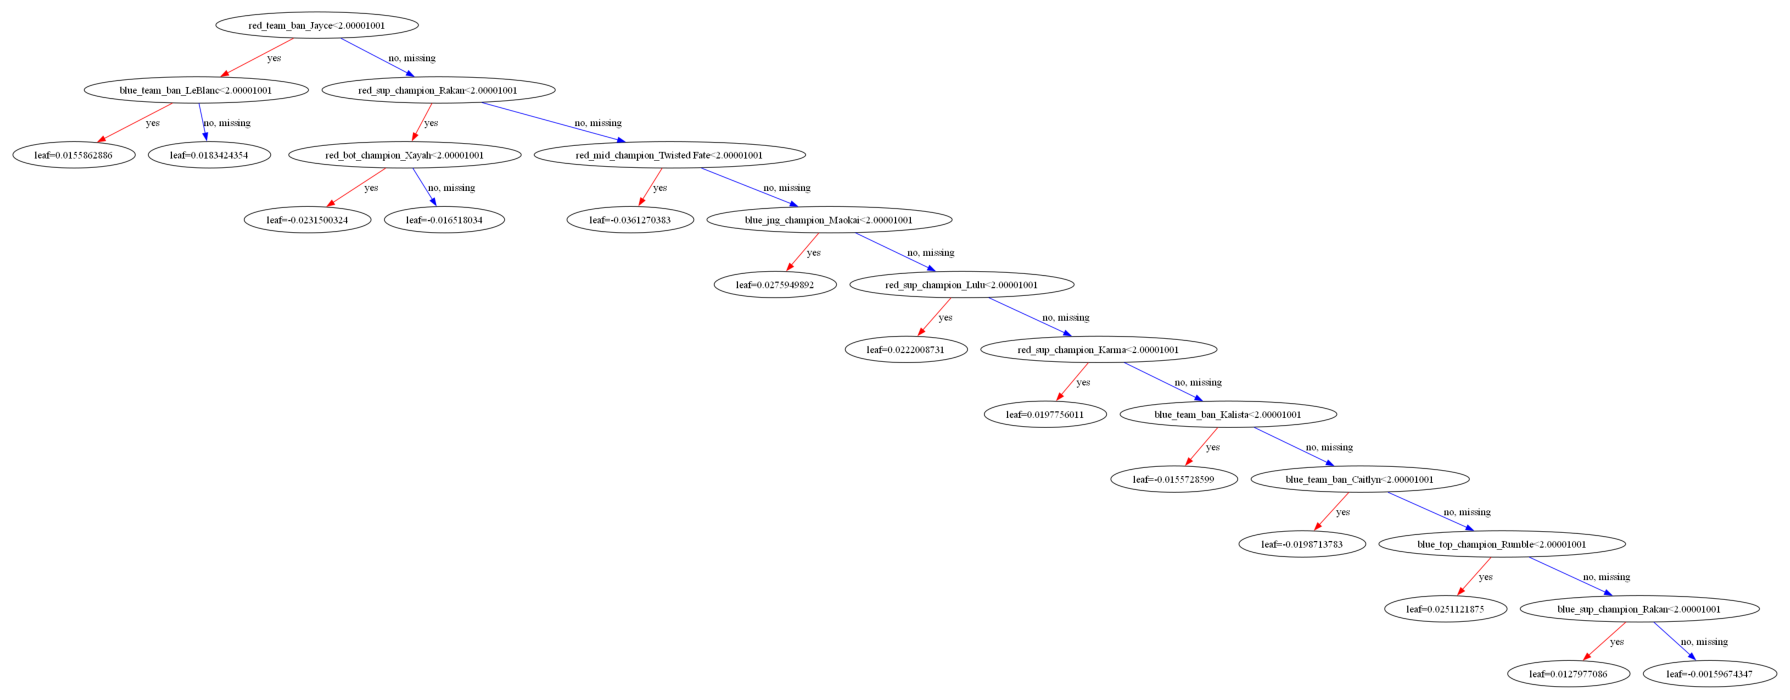

In [47]:
from xgboost import to_graphviz
from io import BytesIO
from PIL import Image

booster = xg_grid_search.best_estimator_.get_booster()
booster.feature_names = list(cat_cols)

dot = to_graphviz(booster,
                  num_trees  = 0,
                  graph_attr = {"rankdir": "LR",
                                "size"   : "18,18",
                                "dpi"    : "400"})

# Render the image.
png = dot.pipe(format="png")
img = Image.open(BytesIO(png))

plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()

When we look at just the first tree, we can see only 2 instances of the model finding relationships between features, including selecting Xayah and Rakan together.

In [48]:
champion_elo_df_train, champion_elo_df_test = train_test_split(champion_elo_df, test_size=0.2, random_state=0)
print(f"Selection correlation between Xayah and Rakan when they are both selected on Red side:  {champion_elo_df_train['red_sup_champion_Rakan'].corr(champion_elo_df_train['red_bot_champion_Xayah']):.2f}")
print(f"Selection correlation between Xayah and Rakan when they are both selected on Blue side: {champion_elo_df_train['blue_sup_champion_Rakan'].corr(champion_elo_df_train['blue_bot_champion_Xayah']):.2f}")

Selection correlation between Xayah and Rakan when they are both selected on Red side:  0.33
Selection correlation between Xayah and Rakan when they are both selected on Blue side: 0.39


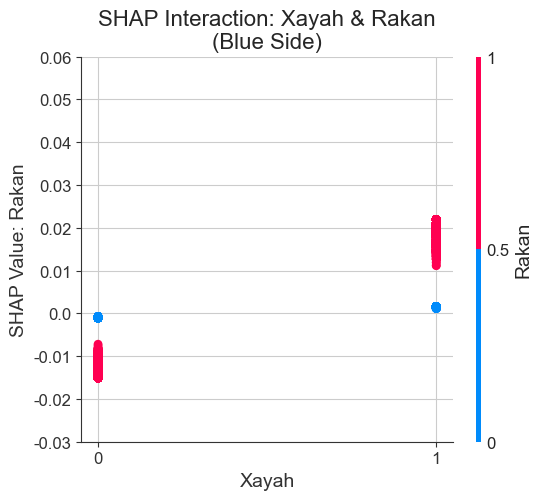

In [49]:
shap_df = pd.DataFrame(shap_values, columns=cat_cols)

train_data_arr = train_data.toarray()

fig, ax = plt.subplots(figsize=(6, 5))
shap.dependence_plot(cat_cols.get_loc("blue_bot_champion_Xayah"),
                     shap_values,
                     train_data_arr,
                     feature_names=cat_cols,
                     interaction_index=cat_cols.get_loc("blue_sup_champion_Rakan"),
                     dot_size=40,
                     ax=ax,
                     show=False)

ax.set_title(f"SHAP Interaction: Xayah & Rakan\n(Blue Side)", size=16)
ax.set_xlabel(f"Xayah", size=14)
ax.set_ylabel(f"SHAP Value: Rakan", size=14)

colour_bar = fig.axes[-1]
colour_bar.set_ylabel("Rakan", size=14)
colour_bar.set_yticks([0, 0.5, 1])
colour_bar.set_yticklabels([0, 0.5, 1], size=12)
ax.set_xticks([0, 1])
ax.set_xticklabels([0, 1], size=12)
ax.set_yticks(np.arange(-0.03, 0.07, 0.01))
ax.set_yticklabels(np.round(np.arange(-0.03, 0.07, 0.01),2), size=12)

plt.show()

***
# Project Evaluation

- The model accurately predicts the results of games 65.8% of the time, and is well calibrated with an ECE of 0.009.

- However, it is not confident enough for games to achieve a strong Brier score, with it being only 0.215.

- Rakan was the champion with the largest cumulative impact on the result of games.

- There are real feature interactions between Champions but there isn't enough data for these interactions to break through the noise.

- Teams have a larger impact on the result of the game than Champions do.

### Real-Life Applications
- Professional Teams using the model to identify the strength of their opponents.

- Betters using the model to increase the accuracy of their pre-game and in-game bets.

### Future Model Development
- Changing the Elo Model to find variables to represent the "margin of victory" and using these to adjust the change in rating of the players.

- Deep feature analysis to further explore what the most important positions are.

- More computational power to employ a larger grid search.

- Editing the model so that it can predict games in real time and creating an interface to input champion data.